<a href="https://colab.research.google.com/github/Shopping-Yuan/ML_Project/blob/Shopping_vscode_branch/DNN_Classification/classify_voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!unzip data.zip
!ls
# %conda install -c nvidia cuda-toolkit

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR
From (redirected): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR&confirm=t&uuid=aec54e06-183b-4e2f-a116-452dcba569be
To: /content/data.zip
100% 372M/372M [00:05<00:00, 64.4MB/s]
Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  sample_data  timit_11


In [2]:
#import pytorch
import torch

# torch.backends.cudnn: set CNN algorithmtorch.backends.cudnn
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# get the current available device ('cpu' or 'cuda')
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(torch.cuda.is_available())
#set random variable
import numpy as np
myseed = 1
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

True


In [3]:
#write data_set_function
#normalize data if needed
import pandas as pd
#Dataset:data_set_function
import numpy as np

def TIMIT_train_val_f(mode,d_l = "both"):

  data = np.load(data_info[mode]["data_path"])
  label = np.load(data_info[mode]["label_path"])
  print('Size of training data: {}'.format(data.shape))
  print('Size of training label: {}'.format(label.shape))
  VAL_RATIO = 0.2
  percent = int(data.shape[0] * (1 - VAL_RATIO))
  train_data, train_label, val_data, val_label = \
  data[:percent], label[:percent].astype(np.int_), data[percent:], label[percent:].astype(np.int_)

  if mode == "train":
    return{"data" : torch.FloatTensor(train_data) , "label" : torch.LongTensor(train_label)}
  elif mode == "val":
    return{"data" : torch.FloatTensor(val_data) , "label" : torch.LongTensor(val_label)}

def TIMIT_test_f(mode,d_l = "data"):
  test = np.load(data_info[mode]["path"])
  print('Size of testing data: {}'.format(test.shape))
  return torch.FloatTensor(test)

#create a dict of functions and path w.r.t. different mode
data_info = {
    "train":{"function":TIMIT_train_val_f,"data_path":"./timit_11/train_11.npy","label_path":"./timit_11/train_label_11.npy","data_or_label":"both"},
    "val":{"function":TIMIT_train_val_f,"data_path":"./timit_11/train_11.npy","label_path":"./timit_11/train_label_11.npy","data_or_label":"both"},
    "test":{"function":TIMIT_test_f,"path":"./timit_11/test_11.npy","data_or_label":"data"}
}

In [4]:
#rewrite class Dataset
from torch.utils.data import Dataset, DataLoader
class Dataset_preparation(Dataset):
  def __init__(self,mode,data_info):
      self.mode = mode
      self.data_or_label = data_info[mode]["data_or_label"]

      if self.data_or_label == "data":
        self.data = data_info[self.mode]["function"](self.mode,"data")
      elif self.data_or_label == "both":
        data_and_label = data_info[self.mode]["function"](self.mode,"both")
        self.data = data_and_label["data"]
        self.label = data_and_label["label"]
      else :
        self.label = data_info[self.mode]["function"](self.mode,"label")["label"]

      self.dim = self.data.shape[1]
      print('Finished reading the {mode} set of Dataset ({len} samples found, each dim = {dim})'
              .format(mode = self.mode, len =len(self.data), dim=self.dim))

  def __getitem__(self, index):
      if self.data_or_label == "data":
        return self.data[index]
      elif self.data_or_label == "both":
        return self.data[index], self.label[index]
      else :
        return self.label[index]
  def __len__(self):
      # Returns the size of the dataset
      return len(self.data)

In [5]:
from torch.utils.data import DataLoader
#decide how to load data
def prep_dataloader(mode,d_info,batch_size,n_jobs=0):
    dataset = Dataset_preparation(mode,d_info)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=False)
    return dataloader

In [26]:
#Model : class Classifier
import torch.nn as nn
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()

        self.net = nn.Sequential(
              nn.Linear(input_dim, 512),
              nn.LeakyReLU(),
              nn.Linear(512, 512),
              nn.LeakyReLU(),
              nn.Linear(512, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 39),
              )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.net(x)
        return x

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

In [7]:
h_paras = {
    # maximum number of epochs
    'n_epochs': 200,
    # mini-batch size for dataloader
    'batch_size': 80,
    # optimization algorithm (optimizer in torch.optim)
    'optimizer': 'Adam',
    # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'optim_hparas': {
        # learning rate of Adam
        'lr': 0.0001,
    },
    'early_stop': 5,
    # your model will be saved here
    'save_path': './model.pth'
}

In [8]:
train_set = prep_dataloader("train",data_info,h_paras['batch_size'])
val_set = prep_dataloader("val",data_info,h_paras['batch_size'])
test_set = prep_dataloader("test",data_info,h_paras['batch_size'])

Size of training data: (1229932, 429)
Size of training label: (1229932,)
Finished reading the train set of Dataset (983945 samples found, each dim = 429)
Size of training data: (1229932, 429)
Size of training label: (1229932,)
Finished reading the val set of Dataset (245987 samples found, each dim = 429)
Size of testing data: (451552, 429)
Finished reading the test set of Dataset (451552 samples found, each dim = 429)


In [9]:
def train(train_set,model_d,optimizer,device):
    # set model to training mode
    model_d.train()
    total_correct_number = 0
    train_loss_list = []
    # iterate through the dataloader
    for data , label in train_set:
      # move data to device (cpu/cuda)
      data_d , label_d = data.to(device), label.to(device)
      # forward pass (compute output tensor)
      pred = (model_d(data_d))
      # get the index of the class with the highest probability
      max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
      correct_number = (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
#      print(correct_number)
      total_correct_number += correct_number
      # compute loss
      loss = model_d.cal_loss(pred , label_d)
      # compute gradient (backpropagation)
      loss.backward()
      # update model with optimizer
      optimizer.step()
      # set optimizer gradient to zero
      optimizer.zero_grad()
      train_loss_list.append(loss.detach().cpu().item())
    acc = total_correct_number/len(train_set.dataset)
    return acc , train_loss_list



In [ ]:
#a = torch.tensor([[0,1],[2,3]])
#b = torch.tensor([[4,1],[5,3]])
#print(type(a == b))

In [10]:
def val(val_set,model_d,device):
    # set model to evalutation mode
    model_d.eval()
    total_correct_number = 0
    total_loss = 0
    # iterate through the dataloader
    for data , label in val_set:
    # move data to device (cpu/cuda)
      data_d, label_d = data.to(device), label.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        total_correct_number += (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
        # compute loss
        mse_loss = model_d.cal_loss(pred, label_d)
      # accumulate loss
      batch_size = len(data_d)
      total_loss += mse_loss.detach().cpu().item() * batch_size

    # compute averaged loss
    totol_size = len(val_set.dataset)
    acc = total_correct_number/totol_size
    avg_loss =  total_loss/totol_size
    return acc, avg_loss

In [11]:
def train_val_process(training_set, validation_set, model, h_paras, device):
    #1: move model to device (cpu/cuda)
    model_d = model.to(device)
    #2: set optimizer = torch.optim.SGD(model_d.parameters(),lr=0.001,momentum=0.9)
    lr_now = h_paras['optim_hparas']["lr"]
    optimizer = getattr(torch.optim, h_paras['optimizer'])(
        model_d.parameters(), lr = lr_now)

    #3: set epoch = h_paras['n_epochs'] = 3000
    n_epochs = h_paras['n_epochs']

    #4: record training accuracy
    acc_record = {'train': [], "val": []}
    #5: record training loss
    loss_record = {'train': [], "val": []}

    #6: setting paras
    # epoch para
    epoch = 0
    # accuracy paras
    best_acc = 0
    # early-stoping paras
    early_stop_cnt = 0
    #start training
    while epoch < n_epochs:

      # Part1 : training process
      # updata model weight and compute model loss
      train_acc , train_loss_list = train(training_set,model_d,optimizer,device)
      # save accuracy to acc_record['train']
      acc_record['train'].append(train_acc)
      # save loss to loss_record['train']
      loss_record['train'].append(train_loss_list)
      # renew epoch para
      epoch += 1
      print('train set accuracy = {:.3f}'.format(train_acc))
      # Part2 validation process
      # After each epoch, test your model
      # on the validation (development) set.
      val_acc , val_loss = val(validation_set, model_d, device)
      # save accuracy to acc_record["val"]
      acc_record["val"].append(val_acc)
      # save loss to loss_record["val"]
      loss_record["val"].append(val_loss)

      print(' model epoch = {:4d}, train_loss = {:.4f} , val_loss = {:.4f})'\
      .format(epoch , train_loss_list[-1] , val_loss))
      # Save model to specified path if your model improved
      torch.save(model_d.state_dict(), h_paras['save_path'])
      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), h_paras["save_path"])
        print('saving model with acc {:.3f}'.format(best_acc))
        early_stop_cnt = 0
      else:
        early_stop_cnt += 1
      # Check early stop criteria
      if early_stop_cnt > h_paras['early_stop']:
          # Stop training if your model stops improving
          # for "h_paras['early_stop']" epochs.
          break
      elif ((early_stop_cnt > 0) and (lr_now>0.0001)):
        lr_now = lr_now * 0.5
        optimizer = getattr(torch.optim, h_paras['optimizer'])(
        model_d.parameters(), lr = lr_now)
#        early_stop_cnt = 0

    print('Finished training after {} epochs'.format(epoch))
    return acc_record , loss_record

In [27]:
# Construct model
model = Classifier(train_set.dataset.dim)
model_acc_record, model_loss_record = train_val_process(train_set, val_set, model, h_paras, device)

train set accuracy = 0.611
 model epoch =    1, train_loss = 1.3237 , val_loss = 1.0485)
saving model with acc 0.670
train set accuracy = 0.682
 model epoch =    2, train_loss = 0.7244 , val_loss = 0.9685)
saving model with acc 0.690
train set accuracy = 0.707
 model epoch =    3, train_loss = 1.0223 , val_loss = 0.9133)
saving model with acc 0.706
train set accuracy = 0.724
 model epoch =    4, train_loss = 0.9169 , val_loss = 0.9007)
saving model with acc 0.708
train set accuracy = 0.739
 model epoch =    5, train_loss = 1.2796 , val_loss = 0.8926)
saving model with acc 0.711
train set accuracy = 0.751
 model epoch =    6, train_loss = 0.3730 , val_loss = 0.8835)
saving model with acc 0.713
train set accuracy = 0.761
 model epoch =    7, train_loss = 1.0827 , val_loss = 0.8805)
saving model with acc 0.715
train set accuracy = 0.771
 model epoch =    8, train_loss = 1.1177 , val_loss = 0.8812)
saving model with acc 0.716
train set accuracy = 0.781
 model epoch =    9, train_loss = 1.0

In [13]:
def test(test_set, model_d, device):
    # set model to evalutation mode
    model_d.eval()
    pred_index = []
    pred_loss = []
    # iterate through the dataloader
    for data in test_set:
      # move data to device (cpu/cuda)
      data_d = data.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        # collect prediction
        pred_index += (max_prob_indexs.tolist())
        pred_loss += (pred.mean(dim = 1).tolist())
    # concatenate all predictions and convert to a numpy array
    np_pred_index , np_pred_loss = np.array(pred_index), np.array(pred_loss)
    pred_dict = { "pred_index" : np_pred_index , "pred_loss" : np_pred_loss }
    return pred_dict



In [14]:
# create model and load weights from checkpoint
model = Classifier(train_set.dataset.dim).to(device)
model_loading = torch.load(h_paras['save_path'], map_location=device)
model.load_state_dict(model_loading,strict=True)

<All keys matched successfully>

In [15]:
import pandas as pd
def save_pred(pred_dict, loss_file_path , index_file_path):
    print('Saving loss to {}'.format(loss_file_path))
    print('Saving acc to {}'.format(index_file_path))
    index = pred_dict["pred_index"]
    loss = pred_dict["pred_loss"]
#    print(acc.shape,loss.shape)
#    for  index ,(a , l) in enumerate(zip(acc,loss)):
#      if index%10000 == 0:
#        print(a , l)
    df_acc = pd.DataFrame({"index": index})
    df_acc.to_csv(index_file_path)
    df_loss = pd.DataFrame({"loss": loss})
    df_loss.to_csv(loss_file_path)

In [16]:
pred_dict = test(test_set, model, device)  # predict cases with your model

In [17]:
save_pred(pred_dict, 'pred_loss.csv','pred_index.csv')         # save prediction file to pred.csv
#del model

Saving loss to pred_loss.csv
Saving acc to pred_index.csv


In [21]:
#%conda install -c conda-forge matplotlib
import matplotlib.pyplot as plt
def plot_learning_curve_loss(loss_record, title=''):
    #plot1 : train loss
    #plot2 : val loss
    train_data = np.array(loss_record['train']).flatten()
    val_data = np.array(loss_record['val']).flatten()
    #setting index range
    total_steps = len(train_data)
    x_1 = range(total_steps)

    x_2 = x_1[::len(train_data) // len(val_data)]

    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.0, 4.)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()
def plot_learning_curve_acc(acc_record, title=''):
    #plot1 : train acc
    #plot2 : val acc
    train_data = np.array(acc_record['train']).flatten()
    val_data = np.array(acc_record['val']).flatten()
    #setting index range
    x_1 = range(len(train_data))
    x_2 = range(len(val_data))

    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.6, 0.8)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    #show legend
    plt.legend()
    #show plot
    plt.show()


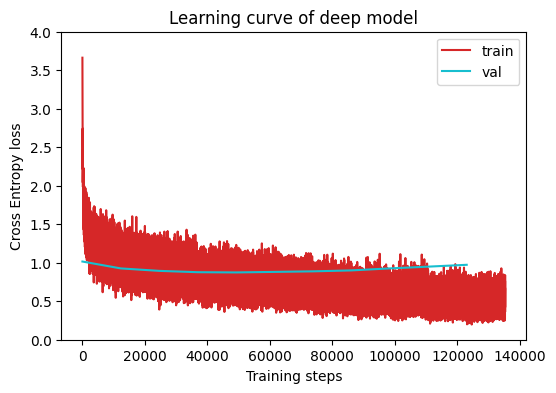

In [22]:
plot_learning_curve_loss(model_loss_record, title='deep model')

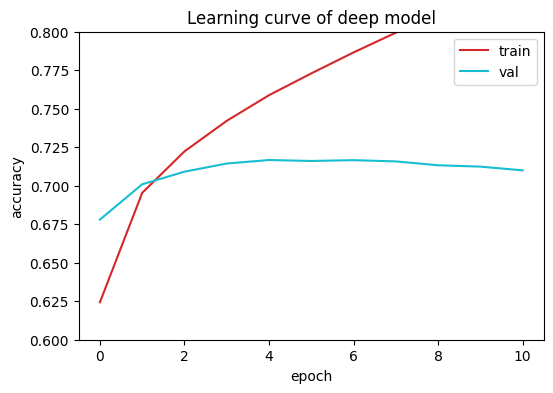

In [23]:
plot_learning_curve_acc(model_acc_record, title='deep model')